<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S11/S11-T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S11/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from config import ModelConfig
from models.CustomCIFARNet import NetCifar10
from train import train
from results import plot_images, plot_graph
from utilities import *
from data_engine import DataEngine
from gradcam.visualize import VisualizeCam
from lr_test.lr_range_test import LRRangeFinder
from lr_test.lr_cycle_plot import LRCyclePlot

#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/


  pip install torch-lr-finder -v --global-option="amp"


Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 512,
  'dropout': 0,
  'epochs': 24,
  'l1_decay': 2e-06,
  'l2_decay': 0.0006,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



Files already downloaded and verified
Files already downloaded and verified


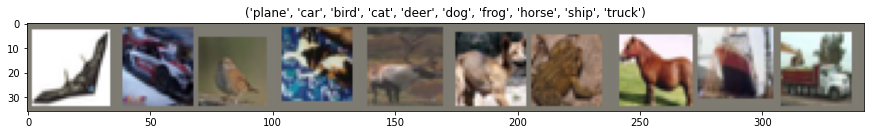

In [2]:
data = DataEngine(args)
data.show_samples()

In [3]:
device = which_device()
model = NetCifar10().to(device)
show_model_summary(model, (3,32,32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        LayerBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [0]:
def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc >= 90.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()


Learning rate search finished. See the graph with {finder_name}.plot()


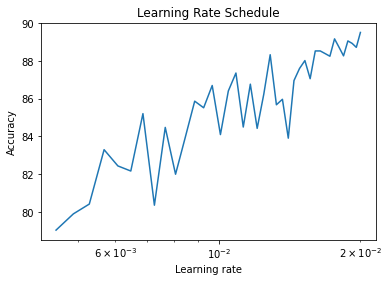

In [5]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-4, end_lr=0.02,
                     epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [6]:
print('Device set to ', device)

Device set to  cuda


In [7]:
best_acc = lr_finder.best_acc
best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))

Best Accuracy: 89.51
Best Learning Rate: 0.020004061224489795


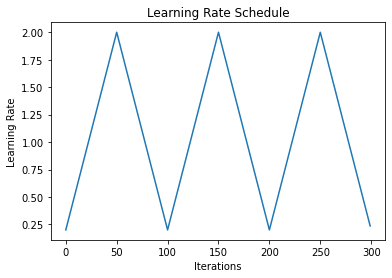

<Figure size 432x288 with 0 Axes>

In [8]:
lrplt = LRCyclePlot({})
lrplt("lr_cycle_plot_test.png")

In [9]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(data.train_loader),
                       epochs=args.epochs, div_factor=10, final_div_factor=1,
                       pct_start=5/args.epochs, anneal_strategy="linear")

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(args.epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==args.epochs-1)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.002000)


L2_loss=276.475 L1_loss=74359.641 Loss=1.55600 Batch_id=97 Accuracy=42.00: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.4187, Accuracy: 5275/10000 (52.75%)

EPOCH: 2 (LR: 0.005609)


L2_loss=277.152 L1_loss=74420.891 Loss=1.26600 Batch_id=97 Accuracy=62.63: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.0110, Accuracy: 6476/10000 (64.76%)

EPOCH: 3 (LR: 0.009217)


L2_loss=277.874 L1_loss=74502.461 Loss=1.01769 Batch_id=97 Accuracy=71.50: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7702, Accuracy: 7398/10000 (73.98%)

EPOCH: 4 (LR: 0.012825)


L2_loss=278.597 L1_loss=74596.062 Loss=0.93194 Batch_id=97 Accuracy=76.87: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.8612, Accuracy: 7312/10000 (73.12%)

EPOCH: 5 (LR: 0.016433)


L2_loss=279.366 L1_loss=74705.500 Loss=1.00089 Batch_id=97 Accuracy=79.34: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.5213, Accuracy: 6351/10000 (63.51%)

EPOCH: 6 (LR: 0.019994)


L2_loss=279.953 L1_loss=74792.273 Loss=0.68744 Batch_id=97 Accuracy=83.01: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6346, Accuracy: 7934/10000 (79.34%)

EPOCH: 7 (LR: 0.019047)


L2_loss=280.421 L1_loss=74829.836 Loss=0.68614 Batch_id=97 Accuracy=85.48: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5377, Accuracy: 8245/10000 (82.45%)

EPOCH: 8 (LR: 0.018099)


L2_loss=280.785 L1_loss=74853.055 Loss=0.73753 Batch_id=97 Accuracy=87.53: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5413, Accuracy: 8293/10000 (82.93%)

EPOCH: 9 (LR: 0.017152)


L2_loss=281.151 L1_loss=74882.656 Loss=0.74290 Batch_id=97 Accuracy=88.30: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5632, Accuracy: 8356/10000 (83.56%)

EPOCH: 10 (LR: 0.016204)


L2_loss=281.431 L1_loss=74890.398 Loss=0.60524 Batch_id=97 Accuracy=90.19: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4891, Accuracy: 8496/10000 (84.96%)

EPOCH: 11 (LR: 0.015257)


L2_loss=281.709 L1_loss=74899.500 Loss=0.60522 Batch_id=97 Accuracy=90.96: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4243, Accuracy: 8678/10000 (86.78%)

EPOCH: 12 (LR: 0.014309)


L2_loss=281.921 L1_loss=74886.219 Loss=0.57168 Batch_id=97 Accuracy=92.50: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3974, Accuracy: 8756/10000 (87.56%)

EPOCH: 13 (LR: 0.013361)


L2_loss=282.102 L1_loss=74871.141 Loss=0.53394 Batch_id=97 Accuracy=93.11: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4745, Accuracy: 8608/10000 (86.08%)

EPOCH: 14 (LR: 0.012414)


L2_loss=282.261 L1_loss=74845.742 Loss=0.53607 Batch_id=97 Accuracy=94.02: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3907, Accuracy: 8839/10000 (88.39%)

EPOCH: 15 (LR: 0.011466)


L2_loss=282.379 L1_loss=74807.969 Loss=0.47785 Batch_id=97 Accuracy=94.66: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5425, Accuracy: 8457/10000 (84.57%)

EPOCH: 16 (LR: 0.010519)


L2_loss=282.477 L1_loss=74766.297 Loss=0.48702 Batch_id=97 Accuracy=95.14: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4140, Accuracy: 8814/10000 (88.14%)

EPOCH: 17 (LR: 0.009571)


L2_loss=282.524 L1_loss=74707.406 Loss=0.47059 Batch_id=97 Accuracy=95.97: 100%|██████████| 98/98 [01:41<00:00,  1.03s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4093, Accuracy: 8810/10000 (88.10%)

EPOCH: 18 (LR: 0.008624)


L2_loss=282.539 L1_loss=74638.125 Loss=0.42128 Batch_id=97 Accuracy=96.37: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3844, Accuracy: 8847/10000 (88.47%)

EPOCH: 19 (LR: 0.007676)


L2_loss=282.531 L1_loss=74565.562 Loss=0.44357 Batch_id=97 Accuracy=97.04: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3638, Accuracy: 8942/10000 (89.42%)

EPOCH: 20 (LR: 0.006729)


L2_loss=282.492 L1_loss=74483.609 Loss=0.39002 Batch_id=97 Accuracy=97.49: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3747, Accuracy: 8925/10000 (89.25%)

EPOCH: 21 (LR: 0.005781)


L2_loss=282.436 L1_loss=74396.031 Loss=0.40900 Batch_id=97 Accuracy=97.78: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3718, Accuracy: 8957/10000 (89.57%)

EPOCH: 22 (LR: 0.004833)


L2_loss=282.366 L1_loss=74311.289 Loss=0.37368 Batch_id=97 Accuracy=98.27: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3679, Accuracy: 8982/10000 (89.82%)

EPOCH: 23 (LR: 0.003886)


L2_loss=282.287 L1_loss=74228.953 Loss=0.36125 Batch_id=97 Accuracy=98.50: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 100 %
Accuracy of  bird : 70 %
Accuracy of   cat : 100 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3523, Accuracy: 9027/10000 (90.27%)

EPOCH: 24 (LR: 0.002938)


L2_loss=282.203 L1_loss=74156.266 Loss=0.36089 Batch_id=97 Accuracy=98.97: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]



Accuracy of plane : 100 %
Accuracy of   car : 85 %
Accuracy of  bird : 100 %
Accuracy of   cat : 75 %
Accuracy of  deer : 100 %
Accuracy of   dog : 87 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 75 %

Test set: Average loss: 0.3575, Accuracy: 9040/10000 (90.40%)



Let us show some of the training images, for fun.



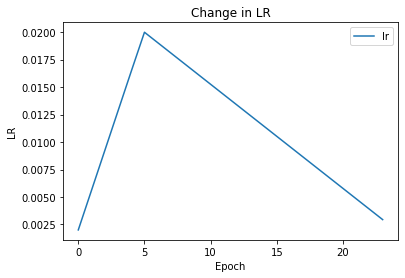

In [10]:
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

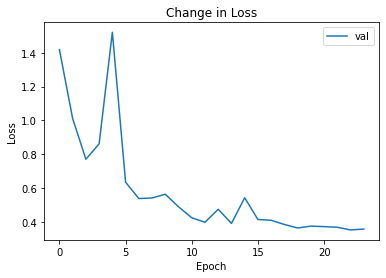

In [11]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

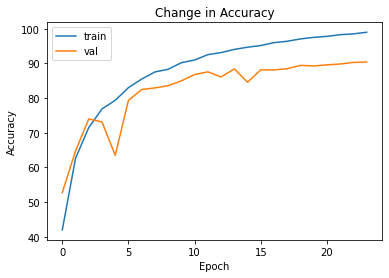

In [12]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

In [0]:

target_layers = ["layer0", "layer1", "layer2", "layer3"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

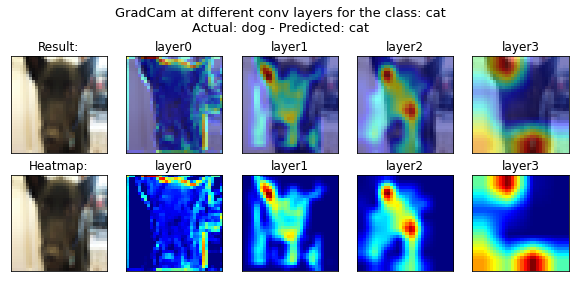

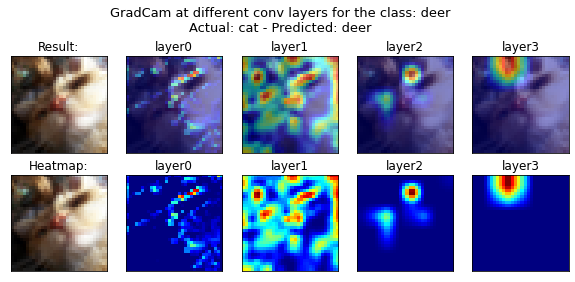

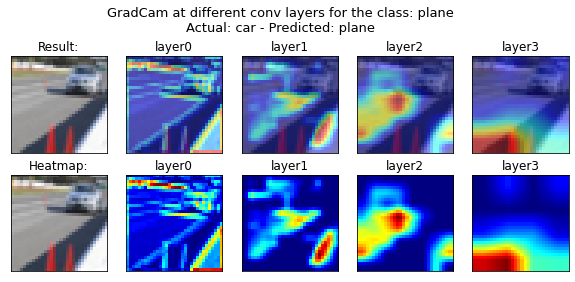

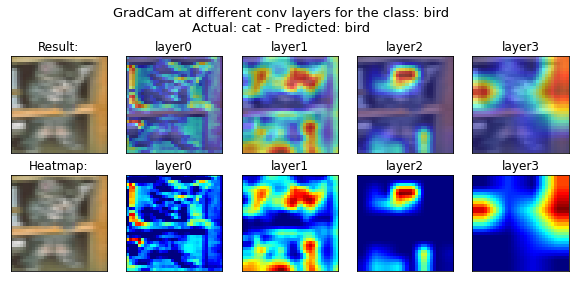

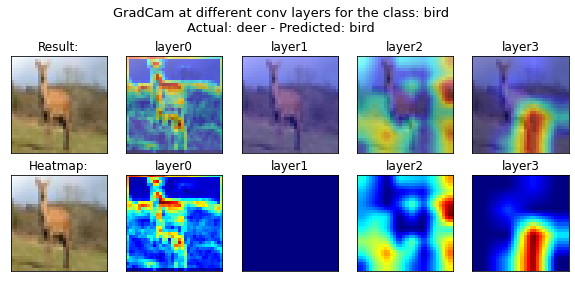

In [14]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")